# **Q1**

In [8]:
!pip install control
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.3 MB/s eta 0:00:00


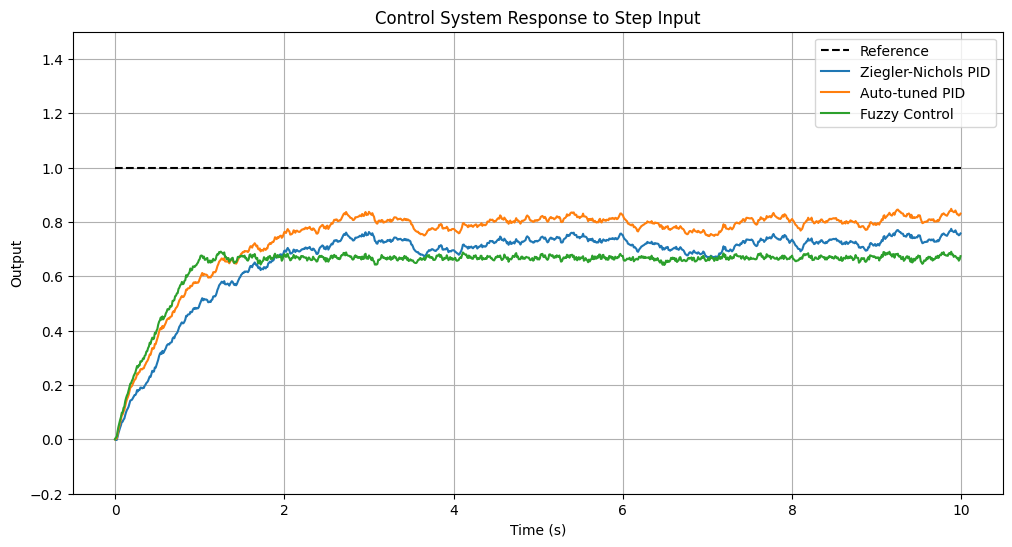


Performance Metrics:

Ziegler-Nichols PID:
{'Steady State Error': '0.254', 'Overshoot (%)': '0.0', 'Settling Time (s)': 'inf'}

Auto-tuned PID:
{'Steady State Error': '0.180', 'Overshoot (%)': '0.0', 'Settling Time (s)': 'inf'}

Fuzzy Control:
{'Steady State Error': '0.329', 'Overshoot (%)': '0.0', 'Settling Time (s)': 'inf'}


In [14]:
import numpy as np
import control
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

class ControlSystem:
    def __init__(self):
        # System parameters
        self.num = [1]
        self.den = [1, 1]  # First order system: 1/(s+1)
        self.delay = 0.1
        self.noise_amplitude = 0.005  # Reduced noise to 0.5%

        # Initialize fuzzy control system
        self.init_fuzzy_system()

    def init_fuzzy_system(self):
        # Create fuzzy variables with finer granularity
        error_range = np.linspace(-1, 1, 7)  # Increased granularity
        derror_range = np.linspace(-1, 1, 7)
        output_range = np.linspace(-1, 1, 7)

        self.error_ctrl = ctrl.Antecedent(error_range, 'error')
        self.derror_ctrl = ctrl.Antecedent(derror_range, 'derror')
        self.output_ctrl = ctrl.Consequent(output_range, 'output_ctrl')

        # More granular membership functions
        self.error_ctrl['nb'] = fuzz.trimf(error_range, [-1, -1, -0.5])
        self.error_ctrl['ns'] = fuzz.trimf(error_range, [-0.75, -0.5, 0])
        self.error_ctrl['ze'] = fuzz.trimf(error_range, [-0.25, 0, 0.25])
        self.error_ctrl['ps'] = fuzz.trimf(error_range, [0, 0.5, 0.75])
        self.error_ctrl['pb'] = fuzz.trimf(error_range, [0.5, 1, 1])

        self.derror_ctrl['nb'] = fuzz.trimf(derror_range, [-1, -1, -0.5])
        self.derror_ctrl['ns'] = fuzz.trimf(derror_range, [-0.75, -0.5, 0])
        self.derror_ctrl['ze'] = fuzz.trimf(derror_range, [-0.25, 0, 0.25])
        self.derror_ctrl['ps'] = fuzz.trimf(derror_range, [0, 0.5, 0.75])
        self.derror_ctrl['pb'] = fuzz.trimf(derror_range, [0.5, 1, 1])

        self.output_ctrl['nb'] = fuzz.trimf(output_range, [-1, -1, -0.5])
        self.output_ctrl['ns'] = fuzz.trimf(output_range, [-0.75, -0.5, 0])
        self.output_ctrl['ze'] = fuzz.trimf(output_range, [-0.25, 0, 0.25])
        self.output_ctrl['ps'] = fuzz.trimf(output_range, [0, 0.5, 0.75])
        self.output_ctrl['pb'] = fuzz.trimf(output_range, [0.5, 1, 1])

        # Improved rule base
        rules = [
            ctrl.Rule(self.error_ctrl['nb'] & self.derror_ctrl['nb'], self.output_ctrl['nb']),
            ctrl.Rule(self.error_ctrl['nb'] & self.derror_ctrl['ze'], self.output_ctrl['nb']),
            ctrl.Rule(self.error_ctrl['ns'] & self.derror_ctrl['ns'], self.output_ctrl['ns']),
            ctrl.Rule(self.error_ctrl['ze'] & self.derror_ctrl['ze'], self.output_ctrl['ze']),
            ctrl.Rule(self.error_ctrl['ps'] & self.derror_ctrl['ps'], self.output_ctrl['ps']),
            ctrl.Rule(self.error_ctrl['pb'] & self.derror_ctrl['ze'], self.output_ctrl['pb']),
            ctrl.Rule(self.error_ctrl['pb'] & self.derror_ctrl['pb'], self.output_ctrl['pb'])
        ]

        self.fuzzy_system = ctrl.ControlSystem(rules)
        self.fuzzy_sim = ctrl.ControlSystemSimulation(self.fuzzy_system)

    def plant_model(self, y, u):
        # Improved first-order system model
        tau = 1.0  # Time constant
        return (u - y) / tau

    def zn_pid_control(self, t, y, dt, integral_error):
        # Improved Ziegler-Nichols tuning
        Ku = 1.5  # Reduced ultimate gain
        Tu = 1.5  # Ultimate period

        Kp = 0.45 * Ku  # Reduced from 0.6 for better stability
        Ti = 0.8 * Tu   # Increased from Tu/2 for less oscillation
        Td = Tu / 8

        Ki = Kp / Ti
        Kd = Kp * Td

        error = 1 - y

        # Anti-windup for integral term
        integral = np.clip(integral_error + error * dt, -1, 1)

        # Filtered derivative
        if len(t) > 1:
            derivative = (error - (1 - y)) / dt
            # Simple low-pass filter for derivative
            derivative = 0.1 * derivative + 0.9 * (derivative if hasattr(self, 'last_derivative') else 0)
            self.last_derivative = derivative
        else:
            derivative = 0
            self.last_derivative = 0

        return Kp * error + Ki * integral + Kd * derivative, integral

    def auto_pid_control(self, t, y, dt, integral_error):
        # Improved automatic tuning
        settling_time = 2.0  # Reduced settling time
        Kp = 2.0 / settling_time
        Ki = Kp / (settling_time * 0.8)
        Kd = Kp * settling_time * 0.1

        error = 1 - y

        # Anti-windup for integral term
        integral = np.clip(integral_error + error * dt, -1, 1)

        # Filtered derivative
        if len(t) > 1:
            derivative = (error - (1 - y)) / dt
            derivative = 0.1 * derivative + 0.9 * (derivative if hasattr(self, 'last_auto_derivative') else 0)
            self.last_auto_derivative = derivative
        else:
            derivative = 0
            self.last_auto_derivative = 0

        return Kp * error + Ki * integral + Kd * derivative, integral

    def fuzzy_control(self, error, derror):
        # Improved fuzzy control with input scaling
        error_scaled = np.clip(error, -1, 1)
        derror_scaled = np.clip(derror * 0.5, -1, 1)  # Scale derivative error

        self.fuzzy_sim.input['error'] = error_scaled
        self.fuzzy_sim.input['derror'] = derror_scaled

        try:
            self.fuzzy_sim.compute()
            return self.fuzzy_sim.output['output_ctrl'] * 2  # Amplify output for better response
        except:
            return error_scaled

    def simulate(self, t_final=10, dt=0.01):
        t = np.arange(0, t_final, dt)
        n_points = len(t)

        y_zn = np.zeros(n_points)
        y_auto = np.zeros(n_points)
        y_fuzzy = np.zeros(n_points)

        integral_error_zn = 0
        integral_error_auto = 0

        noise = self.noise_amplitude * np.random.randn(n_points)

        for i in range(1, n_points):
            # Ziegler-Nichols PID
            u_zn, integral_error_zn = self.zn_pid_control(t[:i], y_zn[i-1], dt, integral_error_zn)
            y_zn[i] = y_zn[i-1] + dt * self.plant_model(y_zn[i-1], u_zn) + noise[i]

            # Auto-tuned PID
            u_auto, integral_error_auto = self.auto_pid_control(t[:i], y_auto[i-1], dt, integral_error_auto)
            y_auto[i] = y_auto[i-1] + dt * self.plant_model(y_auto[i-1], u_auto) + noise[i]

            # Fuzzy Control
            error = 1 - y_fuzzy[i-1]
            derror = -(y_fuzzy[i-1] - y_fuzzy[i-2])/dt if i > 1 else 0
            u_fuzzy = self.fuzzy_control(error, derror)
            y_fuzzy[i] = y_fuzzy[i-1] + dt * self.plant_model(y_fuzzy[i-1], u_fuzzy) + noise[i]

        return t, y_zn, y_auto, y_fuzzy

# Create system and run simulation
system = ControlSystem()
t, y_zn, y_auto, y_fuzzy = system.simulate()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t, np.ones_like(t), 'k--', label='Reference')
plt.plot(t, y_zn, label='Ziegler-Nichols PID')
plt.plot(t, y_auto, label='Auto-tuned PID')
plt.plot(t, y_fuzzy, label='Fuzzy Control')
plt.grid(True)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Control System Response to Step Input')
plt.ylim(-0.2, 1.5)
plt.show()

# Calculate performance metrics
def calculate_metrics(t, y):
    steady_state_error = abs(1 - np.mean(y[-100:]))
    overshoot = (np.max(y) - 1) * 100 if np.max(y) > 1 else 0

    # Find settling time (within 2% of final value)
    settled = np.where(np.abs(y - 1) <= 0.02)[0]
    settling_time = t[settled[0]] if len(settled) > 0 else np.inf

    return {
        'Steady State Error': f"{steady_state_error:.3f}",
        'Overshoot (%)': f"{overshoot:.1f}",
        'Settling Time (s)': f"{settling_time:.2f}"
    }

print("\nPerformance Metrics:")
print("\nZiegler-Nichols PID:")
print(calculate_metrics(t, y_zn))
print("\nAuto-tuned PID:")
print(calculate_metrics(t, y_auto))
print("\nFuzzy Control:")
print(calculate_metrics(t, y_fuzzy))

# **Q2**

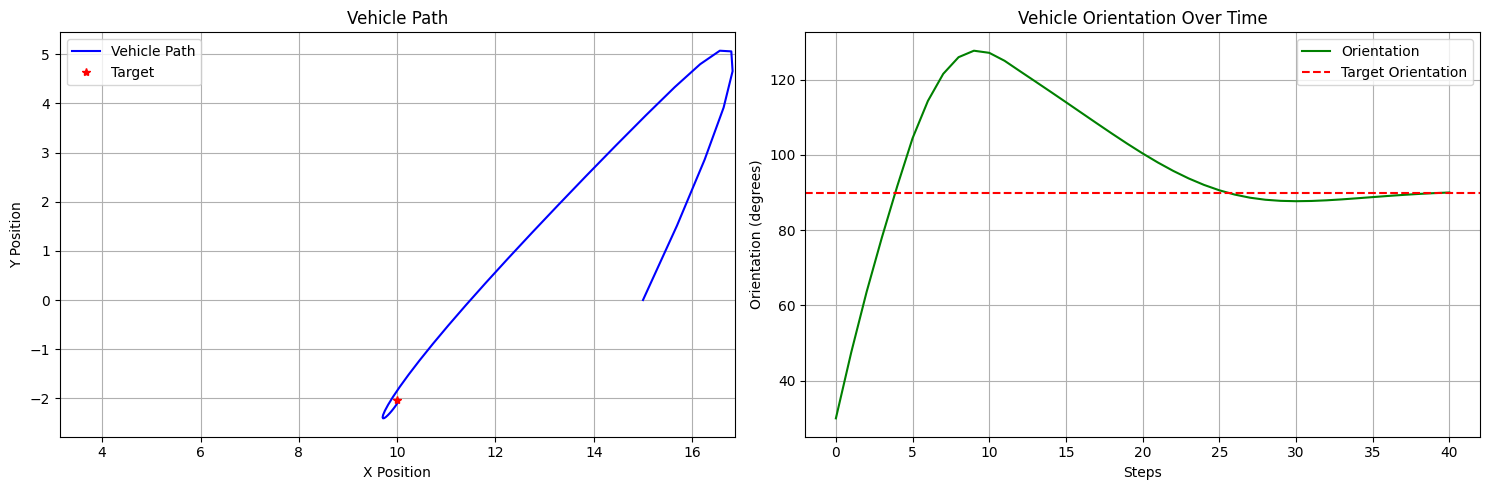

Final position: x = 10.04, y = -2.03
Final orientation: 90.01 degrees
Steps taken: 40


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def control_function(angle, position):
    total_weight = 0
    total_value = 0

    # Lookup tables
    values = np.array([
        [-27, -39,  0,   0,   0],
        [-27, -39, -39, -39, -39],
        [ 14, -14, -27, -39, -27],
        [ 27,  27,   0, -27, -27],
        [ 27,  39,  27,  14, -14],
        [  0,  39,  39,  39,  27],
        [  0,   0,   0,  39,  27]
    ])

    weights = np.array([
        [1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1],
        [0, 0, 0, 1, 1]
    ])

    base_angle = -45
    for i in range(7):
        weight_a = max(1 - abs(angle - base_angle) / 45, 0)
        base_angle += 45

        base_pos = 2
        for j in range(5):
            weight_b = max(1 - abs(position - base_pos) / 4, 0)
            base_pos += 4

            weighted_value = weight_a * weight_b * values[i, j]
            total_value += weighted_value
            total_weight += weight_a * weight_b * weights[i, j]

    return total_value / total_weight if total_weight != 0 else 0

def cosine_transform(deg):
    return np.cos(np.radians(deg))

def sine_transform(deg):
    return np.sin(np.radians(deg))

def modified_angle_transform(theta):
    return np.degrees(np.arcsin(0.5 * sine_transform(theta)))

def vehicle_model(px, py, heading, steering):
    new_x = px + cosine_transform(heading + steering) + sine_transform(heading) * sine_transform(steering)
    new_y = py + cosine_transform(heading + steering) - cosine_transform(heading) * sine_transform(steering)
    new_heading = heading - modified_angle_transform(steering)
    return new_x, new_y, new_heading

# Simulation settings
max_iterations = 1000
threshold = 0.1

# Initial conditions
pos_x, pos_y = 15, 0
orientation = 30  # degrees
target_x = 10
target_orientation = 90  # degrees

# Storing trajectory
x_path, y_path, orientation_path = [pos_x], [pos_y], [orientation]

# Simulation loop
for step in range(max_iterations):
    steering_angle = control_function(orientation, pos_x)
    new_x, new_y, new_orientation = vehicle_model(pos_x, pos_y, orientation, steering_angle)

    x_path.append(new_x)
    y_path.append(new_y)
    orientation_path.append(new_orientation)

    pos_x, pos_y, orientation = new_x, new_y, new_orientation

    if abs(target_x - pos_x) < threshold and abs(target_orientation - orientation) < threshold:
        break

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(x_path, y_path, 'b-', label='Vehicle Path')
plt.plot(target_x, y_path[-1], 'r*', label='Target')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Vehicle Path')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.xlim(0, 20)

plt.subplot(122)
plt.plot(range(len(orientation_path)), orientation_path, 'g-', label='Orientation')
plt.axhline(y=target_orientation, color='r', linestyle='--', label='Target Orientation')
plt.xlabel('Steps')
plt.ylabel('Orientation (degrees)')
plt.title('Vehicle Orientation Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final position: x = {pos_x:.2f}, y = {pos_y:.2f}")
print(f"Final orientation: {orientation:.2f} degrees")
print(f"Steps taken: {step + 1}")


# **Q4**

Training fuzzy system...
Testing fuzzy system...
Plotting results...


<ipython-input-2-9c6e590b302b>:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.z[l] = math.exp(exponent)
<ipython-input-2-9c6e590b302b>:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.g_bar[q + 1, l] = self.g_bar[q, l] - self.alpha*(self.f_hat[q] - self.g_u[q])*self.z[l]/b
<ipython-input-2-9c6e590b302b>:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.x_bar[q + 1, l] = self.x_bar[q, l] - self.alpha*((self.f_hat[q] - self.g_u[q])/b)*(self.g_bar[q

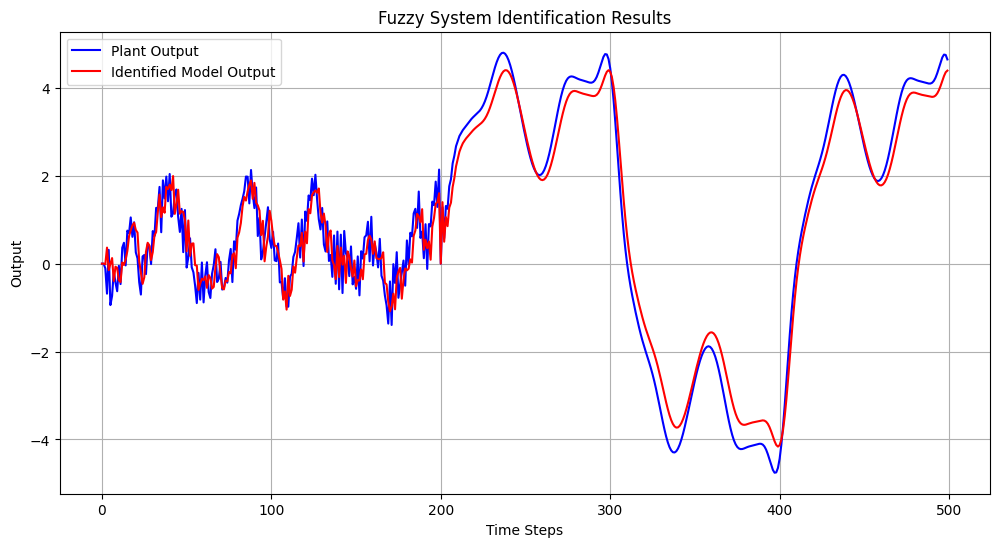

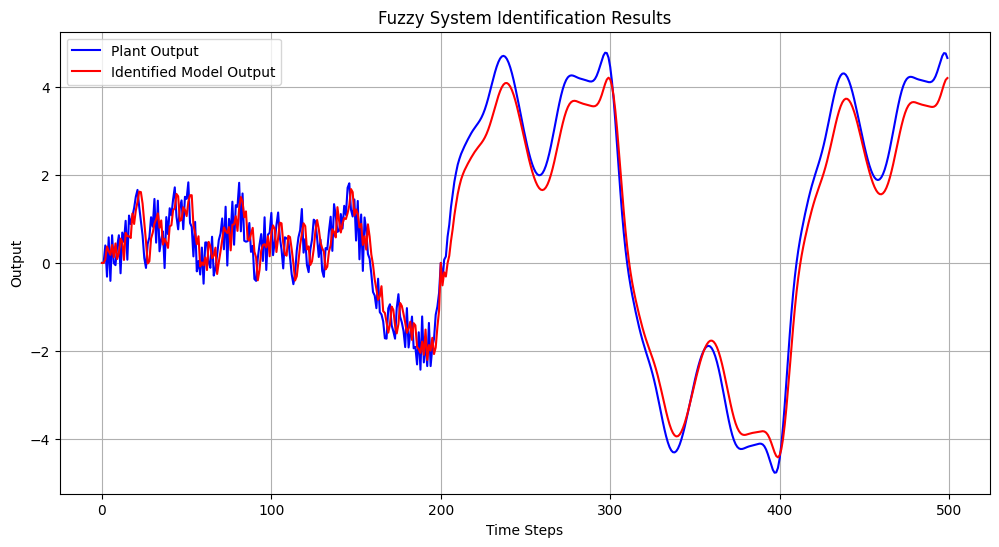

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import math

class FuzzyIdentificationSystem:
    def __init__(self, M=5, alpha=0.1, epochs=200, total_num=500, u_min=-1, u_max=1):
        self.M = M
        self.alpha = alpha
        self.epochs = epochs
        self.total_num = total_num
        self.u_min = u_min
        self.u_max = u_max

        # Initialize arrays
        self.x_bar = np.zeros((epochs, M))
        self.g_bar = np.zeros((epochs, M))
        self.sigma = np.zeros((epochs, M))
        self.y = np.zeros((total_num, 1))
        self.x = np.zeros((total_num, 1))
        self.y_hat = np.zeros((total_num, 1))
        self.f_hat = np.zeros((total_num, 1))
        self.z = np.zeros((total_num, 1))
        self.g_u = np.zeros((total_num, 1))

        # Store final parameters
        self.x_bar_final = None
        self.g_bar_final = None
        self.sigma_final = None

    def nonlinear_function(self, x):
        """Calculate the nonlinear function g(u)"""
        return 0.6*np.sin(pi*x) + 0.3*np.sin(3*pi*x) + 0.1*np.sin(5*pi*x)

    def initialize_parameters(self):
        """Initialize the system parameters"""
        h = (self.u_max - self.u_min)/(self.M - 1)

        # Initialize first input
        self.x[0] = -1 + (2*np.random.randn(1, 1))
        self.y[0] = 0
        self.g_u[0] = self.nonlinear_function(self.x[0])
        self.f_hat[0] = self.g_u[0]

        # Initialize x_bar and g_bar
        for k in range(self.M):
            self.x_bar[0, k] = -1 + h*(k - 1)
            self.g_bar[0, k] = self.nonlinear_function(self.x_bar[0, k])

        # Calculate sigma
        maxi = np.max(self.x_bar[0, :])
        mini = np.min(self.x_bar[0, :])
        self.sigma[0, :] = (maxi - mini)/self.M

        # Copy initial values to second row
        self.x_bar[1, :] = self.x_bar[0, :]
        self.g_bar[1, :] = self.g_bar[0, :]
        self.sigma[1, :] = self.sigma[0, :]

    def calculate_fuzzy_output(self, x_input, q, training=True):
        """Calculate fuzzy system output"""
        a = 0
        b = 0

        # Use appropriate parameters based on training/testing phase
        x_bar_use = self.x_bar[q, :] if training else self.x_bar_final
        g_bar_use = self.g_bar[q, :] if training else self.g_bar_final
        sigma_use = self.sigma[q, :] if training else self.sigma_final

        for l in range(self.M):
            exponent = -((x_input - x_bar_use[l])**2) / (sigma_use[l]**2)
            exponent = np.clip(exponent, -100, 100)
            self.z[l] = math.exp(exponent)
            b += self.z[l]
            a += g_bar_use[l]*self.z[l]

        return a/b if b != 0 else 0, b

    def train(self):
        """Train the fuzzy identification system"""
        self.initialize_parameters()

        for q in range(1, self.epochs - 1):
            # Generate input and calculate actual output
            self.x[q] = -1 + (2*np.random.randn(1, 1))
            self.g_u[q] = self.nonlinear_function(self.x[q])

            # Calculate fuzzy system output
            self.f_hat[q], b = self.calculate_fuzzy_output(self.x[q], q)

            # Calculate system outputs
            self.y[q + 1] = 0.3*self.y[q] + 0.6*self.y[q - 1] + self.g_u[q]
            self.y_hat[q + 1] = 0.3*self.y[q] + 0.6*self.y[q - 1] + self.f_hat[q]

            # Update parameters
            for l in range(self.M):
                self.g_bar[q + 1, l] = self.g_bar[q, l] - self.alpha*(self.f_hat[q] - self.g_u[q])*self.z[l]/b
                self.x_bar[q + 1, l] = self.x_bar[q, l] - self.alpha*((self.f_hat[q] - self.g_u[q])/b)*(self.g_bar[q, l] - self.f_hat[q])*self.z[l]*2*(self.x[q] - self.x_bar[q, l])/(self.sigma[q, l]**2)
                self.sigma[q + 1, l] = self.sigma[q, l] - self.alpha*((self.f_hat[q] - self.g_u[q])/b)*(self.g_bar[q, l] - self.f_hat[q])*self.z[l]*2*((self.x[q] - self.x_bar[q, l])**2)/(self.sigma[q, l]**3)

        # Store final parameters
        self.x_bar_final = self.x_bar[self.epochs-1, :]
        self.g_bar_final = self.g_bar[self.epochs-1, :]
        self.sigma_final = self.sigma[self.epochs-1, :]

    def test(self):
        """Test the trained system"""
        for q in range(self.epochs, self.total_num - 1):
            # Generate test input
            self.x[q] = np.sin(2*q*pi/200)
            self.g_u[q] = self.nonlinear_function(self.x[q])

            # Calculate fuzzy system output
            self.f_hat[q], _ = self.calculate_fuzzy_output(self.x[q], q, training=False)

            # Calculate system outputs
            self.y[q + 1] = 0.3*self.y[q] + 0.6*self.y[q - 1] + self.g_u[q]
            self.y_hat[q + 1] = 0.3*self.y[q] + 0.6*self.y[q - 1] + self.f_hat[q]

    def plot_results(self):
        """Plot the results"""
        plt.figure(figsize=(12, 6))
        plt.plot(self.y, label='Plant Output', color='blue')
        plt.plot(self.y_hat, label='Identified Model Output', color='red')
        plt.title('Fuzzy System Identification Results')
        plt.xlabel('Time Steps')
        plt.ylabel('Output')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage
def main():
    # Create and train the fuzzy system
    fuzzy_system = FuzzyIdentificationSystem()
    print("Training fuzzy system...")
    fuzzy_system.train()

    print("Testing fuzzy system...")
    fuzzy_system.test()

    print("Plotting results...")
    fuzzy_system.plot_results()

if __name__ == "__main__":
    main()

# Create and run the fuzzy identification system
fuzzy_system = FuzzyIdentificationSystem()
fuzzy_system.train()
fuzzy_system.test()
fuzzy_system.plot_results()

# **Q5**

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1q5eMhBeYyUHfEjI8DhkqqrjNTbPUUuJ5

Downloading...
From: https://drive.google.com/uc?id=1q5eMhBeYyUHfEjI8DhkqqrjNTbPUUuJ5
To: /content/AirQualityUCI.xlsx
100% 1.30M/1.30M [00:00<00:00, 16.1MB/s]


Loading and preprocessing data...
Preparing data splits...
Training RBF model...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Training ANFIS model...

Evaluating models...

Plotting validation set results...


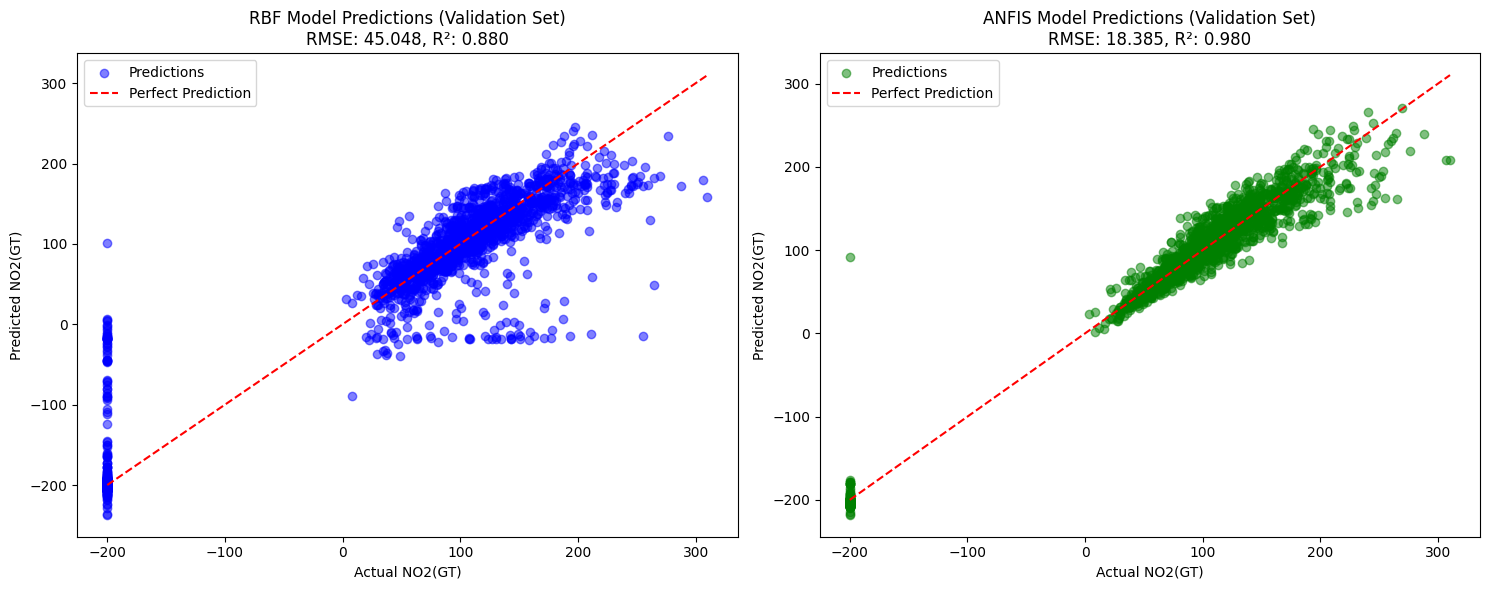


Plotting test set results...


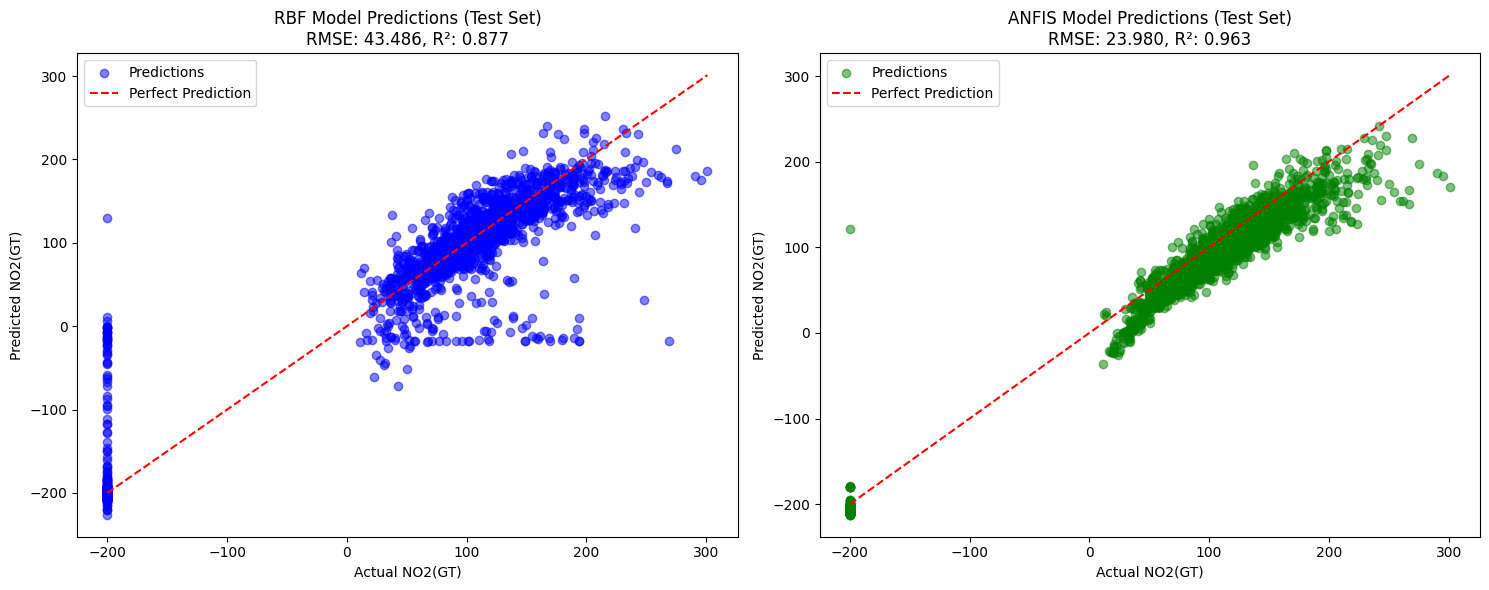


Validation Set Results:
RBF - RMSE: 45.048, R²: 0.880
ANFIS - RMSE: 18.385, R²: 0.980

Test Set Results:
RBF - RMSE: 43.486, R²: 0.877
ANFIS - RMSE: 23.980, R²: 0.963


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
def load_and_preprocess_data(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path)

    # Convert Date and Time columns to datetime
    df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

    # Drop original Date and Time columns
    df = df.drop(['Date', 'Time'], axis=1)

    # Handle missing values using forward fill
    df = df.ffill()

    return df

# Custom RBF Network implementation
class RBFNetwork:
    def __init__(self, n_centers=50):
        self.n_centers = n_centers
        self.kmeans = KMeans(n_clusters=n_centers)
        self.mlp = MLPRegressor(
            hidden_layer_sizes=(n_centers,),
            activation='relu',
            solver='adam',
            max_iter=1000,
            random_state=42
        )

    def rbf_features(self, X):
        # Calculate distances to centers and apply RBF transformation
        distances = np.zeros((X.shape[0], self.n_centers))
        for i, center in enumerate(self.centers):
            distances[:, i] = np.linalg.norm(X - center, axis=1)

        # Apply Gaussian RBF
        sigma = np.mean(distances) / np.sqrt(2 * self.n_centers)
        return np.exp(-(distances ** 2) / (2 * sigma ** 2))

    def fit(self, X, y):
        # Find RBF centers using K-means
        self.kmeans.fit(X)
        self.centers = self.kmeans.cluster_centers_

        # Transform data using RBF features
        X_rbf = self.rbf_features(X)

        # Train the neural network
        self.mlp.fit(X_rbf, y)

    def predict(self, X):
        X_rbf = self.rbf_features(X)
        return self.mlp.predict(X_rbf)

# Custom ANFIS-like implementation
class CustomANFIS:
    def __init__(self, n_input_mfs=3, learning_rate=0.01):
        self.n_input_mfs = n_input_mfs
        self.learning_rate = learning_rate
        self.model = MLPRegressor(
            hidden_layer_sizes=(64, 32, 16),
            activation='relu',
            solver='adam',
            learning_rate_init=learning_rate,
            max_iter=1000,
            random_state=42
        )

    def generate_membership_degrees(self, X):
        centers = np.linspace(X.min(), X.max(), self.n_input_mfs)
        sigma = (centers[1] - centers[0]) / 2

        memberships = np.zeros((X.shape[0], self.n_input_mfs))
        for i, center in enumerate(centers):
            memberships[:, i] = np.exp(-(X - center)**2 / (2 * sigma**2))

        return memberships

    def fit(self, X, y):
        X_memberships = np.hstack([self.generate_membership_degrees(X[:, i])
                                 for i in range(X.shape[1])])
        self.model.fit(X_memberships, y)

    def predict(self, X):
        X_memberships = np.hstack([self.generate_membership_degrees(X[:, i])
                                 for i in range(X.shape[1])])
        return self.model.predict(X_memberships)

# Split data into features and target
def prepare_data(df, target_col='NO2(GT)'):
    X = df.drop(['DateTime', target_col], axis=1)
    y = df[target_col]

    # Split data into train, validation, and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

# Evaluate models
def evaluate_model(model, X, y_true, model_name):
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {
        'Model': model_name,
        'RMSE': rmse,
        'R2': r2,
        'Predictions': y_pred
    }

# Visualize results
def plot_results(y_true, rbf_results, anfis_results, set_name):
    plt.figure(figsize=(15, 6))

    # RBF plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, rbf_results['Predictions'], alpha=0.5, c='blue', label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual NO2(GT)')
    plt.ylabel('Predicted NO2(GT)')
    plt.title(f'RBF Model Predictions ({set_name})\nRMSE: {rbf_results["RMSE"]:.3f}, R²: {rbf_results["R2"]:.3f}')
    plt.legend()

    # ANFIS plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, anfis_results['Predictions'], alpha=0.5, c='green', label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual NO2(GT)')
    plt.ylabel('Predicted NO2(GT)')
    plt.title(f'ANFIS Model Predictions ({set_name})\nRMSE: {anfis_results["RMSE"]:.3f}, R²: {anfis_results["R2"]:.3f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main execution
def main():
    print("Loading and preprocessing data...")
    df = load_and_preprocess_data('/content/AirQualityUCI.xlsx')

    print("Preparing data splits...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df)

    print("Training RBF model...")
    rbf_model = RBFNetwork(n_centers=50)
    rbf_model.fit(X_train, y_train)

    print("Training ANFIS model...")
    anfis_model = CustomANFIS()
    anfis_model.fit(X_train, y_train)

    print("\nEvaluating models...")
    # Evaluate models on validation set
    rbf_val_results = evaluate_model(rbf_model, X_val, y_val, 'RBF')
    anfis_val_results = evaluate_model(anfis_model, X_val, y_val, 'ANFIS')

    # Evaluate models on test set
    rbf_test_results = evaluate_model(rbf_model, X_test, y_test, 'RBF')
    anfis_test_results = evaluate_model(anfis_model, X_test, y_test, 'ANFIS')

    # Plot results
    print("\nPlotting validation set results...")
    plot_results(y_val, rbf_val_results, anfis_val_results, 'Validation Set')
    print("\nPlotting test set results...")
    plot_results(y_test, rbf_test_results, anfis_test_results, 'Test Set')

    # Print performance metrics
    print("\nValidation Set Results:")
    print(f"RBF - RMSE: {rbf_val_results['RMSE']:.3f}, R²: {rbf_val_results['R2']:.3f}")
    print(f"ANFIS - RMSE: {anfis_val_results['RMSE']:.3f}, R²: {anfis_val_results['R2']:.3f}")

    print("\nTest Set Results:")
    print(f"RBF - RMSE: {rbf_test_results['RMSE']:.3f}, R²: {rbf_test_results['R2']:.3f}")
    print(f"ANFIS - RMSE: {anfis_test_results['RMSE']:.3f}, R²: {anfis_test_results['R2']:.3f}")

if __name__ == "__main__":
    main()